<a href="https://colab.research.google.com/github/AbuKaisar24/Bengali-to-English-Machine-Translation/blob/master/BNMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 99kB/s 
     |████████████████████████████████| 3.2MB 33.7MB/s 
     |████████████████████████████████| 491kB 43.1MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional
from keras.layers import Activation, dot, concatenate
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from gensim.models import Word2Vec
from tqdm import tqdm_notebook
import nltk
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NMT.xlsx to NMT (1).xlsx


In [ ]:
import io
data = io.BytesIO(uploaded['NMT.xlsx']) 


In [ ]:
import pandas as pd   
df = pd.read_excel(data)
#df.sheet_names
df.head()

,English,Bengali
0,Like usual Eid-Festival was organized by diffe...,'এবারও দেশের বিভিন্ন টেলিভিশন চ্যানেলে ছিল ঈদ-...
1,Programs were telecasted for five days.,'পাঁচ দিন ধরে চলেছে অনুষ্ঠানমালা'
2,The special arrangement is made with those.,'সেগুলো নিয়েই এ বিশেষ আয়োজন'
3,And those programs had different names.,'আর সেসব অনুষ্ঠানের ছিল বাহারি নামও'
4,It broadcasted beyond the borders of the country.,'এর প্রচারের আওতা দেশের সীমানা পেরিয়ে বিদেশ পর...


In [ ]:
df.English = df.English.apply(lambda x: str(x.lower()))
df.Bengali = df.Bengali.apply(lambda x: str(x))
exclude = set(string.punctuation)
df.English = df.English.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df.Bengali = df.Bengali.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
df.sample(10)

,English,Bengali
1032,which thing is very much available in the mari...,৯ সামুদ্রিক মাছে কোনটি প্রচুর পরিমাণ পাওয়া যায়
78,17614 hours are spent only to telecast adverti...,এর মধ্যে ১৭৬১৪ ঘণ্টা ব্যয় হয়েছে শুধু বিজ্ঞাপন ...
799,sablu is the son of poor rickshaw driver prana...,সাবলু দরিদ্র রিকশাচালক প্রণব কান্তি নাথের ছেলে
1695,rice has been collected in accordance with the...,সরকারি নিয়মনীতি মেনেই চাল সংগ্রহ হয়েছে
994,‘answer food creates immune system in the body’,উত্তর খাদ্যই দেহের রোগ প্রতিরোধ ক্ষমতা গড়ে তোলে
893,but repeatedly they are to be frustrated,কিন্তু বারবারই তাদের হতাশ হতে হয়
303,tv channels embellished their programs with ra...,দেশের টিভি চ্যানেলগুলো ঈদে আনন্দের ডালি সাজিয়ে...
1637,his family is crowded with son daughter in law...,ছেলে ছেলের বউ নাতিনাতনিতে পরিপূর্ণ তাঁর সংসার
256,i was sitting with great hope to see humayun a...,বড় আশা নিয়ে বসেছিলাম হুমায়ূন আহমেদের নাটক দেখতে
1192,the strong circle has taken possession of the ...,সেই চরের দখল নিয়েছে শক্তিশালী চক্র


#seq2seq



In [ ]:
import sys
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt') # Uncomment if running from Google Colab
from nltk.translate.bleu_score import corpus_bleu
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df.Bengali = df.Bengali.apply(lambda x : 'START_  '+ x + ' _END')

In [ ]:
input_texts = list()
target_texts = list()
input_characters = set()
target_characters = set()

In [ ]:
for i in df.English:
  input_texts.append(str(i))
for i in df.Bengali:
  target_texts.append(str(i)) 

In [ ]:

# Source Vocabulary
Source_vocabulary=set()
source_length_list=[]
for line in input_texts:
    source_length_list.append(len(nltk.word_tokenize(line)))
    for word in nltk.word_tokenize(line):
        if word not in Source_vocabulary:
            Source_vocabulary.add(word)
 

# Target Vocabulary
target_vocabulary=set()
target_length_list=[]
for line in target_texts:
    target_length_list.append(len(nltk.word_tokenize(line)))
    for word in nltk.word_tokenize(line):
        if word not in target_vocabulary:
            target_vocabulary.add(word)

num_source_tokens = len(Source_vocabulary)
num_target_tokens = len(target_vocabulary)

max_source_seq_length = np.max(source_length_list)
max_target_seq_length = np.max(target_length_list)

In [ ]:
input_texts_train, input_texts_test, target_texts_train, target_texts_test = train_test_split(
    input_texts,target_texts, test_size=0.20, random_state=42)

In [ ]:
print('Number of samples:', len(input_texts))
print('Number of unique source language tokens:', num_source_tokens)
print('Number of unique target language tokens:', num_target_tokens)
print('Max sequence length of source language:', max_source_seq_length)
print('Max sequence length of target language:', max_target_seq_length)
print("Source Vocabulary",Source_vocabulary)
print("Target Vocabulary",target_vocabulary)

Number of samples: 1781
Number of unique source language tokens: 4024
Number of unique target language tokens: 5171
Max sequence length of source language: 21
Max sequence length of target language: 25
Source Vocabulary {'universities', 'suit', 'declare', 'islamic', 'devoted', 'perosn', 'fairly', 'power', 'double', 'quickly', 'question', 'rais', 'rainit', 'students', 'love', 'purchase', 'injured', 'jessore', 'obeyed', 'creating', 'businessman', 'das', 'carried', 'canceled', 'talking', 'enthusiasm', 'sands', 'welcomed', 'esho', 'waste', 'elements', 'shatkania', 'ointment', 'mehendi', 'maryam', 'lavlu', 'zillurs', 'accept', 'excellency', 'charity', 'toward', 'listen', 'build', 'fund', 'megawatt', 'independence', 'shares', 'statement', 'leaders', 'features', 'sun', 'nirob', 'innings', 'british', 'threatens', 'zone', 'puller', 'explained', 'consideration', 'still', 'mejbaur', 'why', 'momentum', 'kashmirs', 'sorrows', 'swimming', 'mushfiqur', 'contemporary', 'fraud', 'dunn', 'teacher', 'fol

In [ ]:
input_token_index = dict([(word,i) for i, word in enumerate(Source_vocabulary)])
target_token_index= dict([(word,i) for i, word in enumerate(target_vocabulary)])

In [ ]:
embeddings_index = dict()
f = open('drive/My Drive/Colab Notebooks/glove.txt', 'r', encoding='utf8', errors='ignore') #bn_w2v_model.text
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((num_source_tokens, 50))
for word,i in input_token_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        print(word)
        print("Not Found")

perosn
Not Found
rainit
Not Found
esho
Not Found
shatkania
Not Found
mehendi
Not Found
lavlu
Not Found
zillurs
Not Found
nirob
Not Found
mejbaur
Not Found
wahiduzzaman
Not Found
moveableimmovable
Not Found
abujh
Not Found
himthe
Not Found
badarkhali
Not Found
nalinikant
Not Found
patiencethis
Not Found
gadhanagor
Not Found
ahmmed
Not Found
hasinas
Not Found
surovie
Not Found
panchayet
Not Found
nalitabari
Not Found
mahathero
Not Found
dhinnesh
Not Found
abhaynagar
Not Found
panamnagar
Not Found
17614
Not Found
afsarul
Not Found
anandamela
Not Found
star14
Not Found
kondia
Not Found
ramdashat
Not Found
wwwdigitalbagerhatorg
Not Found
hemonto
Not Found
daruchini
Not Found
harrdy
Not Found
capasiaa
Not Found
adrita
Not Found
galm
Not Found
fourmonths
Not Found
kidszone
Not Found
coela
Not Found
ensurity
Not Found
pulak
Not Found
dompara
Not Found
chondipur
Not Found
chokher
Not Found
conjuming
Not Found
hassans
Not Found
mohommad
Not Found
groupinglobbying
Not Found
lashkaretaiba
Not Foun

In [ ]:
embedding_matrix.shape

(4024, 50)

In [ ]:
print(embedding_matrix[0])

[-0.65503001  0.55212998 -0.28143999 -1.10759997 -0.80285001 -0.50288999
 -0.45263001 -0.56634003 -0.40766001  0.065814    0.24498001 -0.41909
  0.55291998 -0.34400001 -0.62248999  0.07158     0.22541     0.41833001
  0.31944001  0.50634003  1.02390003  0.013704    0.10401     0.77249002
 -0.76463002 -1.31060004  0.063183   -1.40390003 -2.01230001 -0.60715002
  2.69309998  0.98837     0.29280999 -1.37609994  0.18759     0.022284
 -0.37362999  1.04170001  0.062304    0.30410001 -0.39769    -0.60825998
  1.12720001  1.18570006 -0.25953001  0.2388     -0.30450001  0.75515997
 -0.68009001 -0.57788002]


In [ ]:

# Create matrix with zeros for source and target data -
encoder_input_data_train = np.zeros(
    (len(input_texts_train), max_source_seq_length),
    dtype='float32')
decoder_input_data_train = np.zeros(
    (len(target_texts_train), max_target_seq_length),
    dtype='float32')

# Create matrix with zeros for target label
decoder_target_data_train = np.zeros(
    (len(target_texts_train), max_target_seq_length, num_target_tokens),
    dtype='float32')

In [ ]:

# update the matrix data with the index from the unique index -
for i, (input_text, target_text) in enumerate(zip(input_texts_train, target_texts_train)):
    for t, word in enumerate(nltk.word_tokenize(input_text)):
        encoder_input_data_train[i, t] = input_token_index[word]
    for t, word in enumerate(nltk.word_tokenize(target_text)):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data_train[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            # will update as one hot vector at the labels 
            decoder_target_data_train[i, t - 1, target_token_index[word]] = 1.

In [ ]:

print(encoder_input_data_train.shape)
print(decoder_input_data_train.shape)
print(decoder_target_data_train.shape)

(1424, 21)
(1424, 25)
(1424, 25, 5171)


In [ ]:
embedding_size = 50

In [ ]:
# Encoder Input
encoder_inputs = Input(shape=(None,))
# Embedding layer (non-trainable) with the Glove Embedding weights
encoder_embedd=  Embedding(num_source_tokens, embedding_size , weights=[embedding_matrix],
                input_shape=(max_source_seq_length,), trainable=False)(encoder_inputs)
# LSTM Layer
encoder = LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embedd)
encoder_states = [state_h, state_c] # Encoder States

In [ ]:
# decoder code goes here

decoder_inputs = Input(shape=(None,))
# Decoder Embedding with Keras Default Embedding (will be trained)
decoder_embedd=  Embedding(num_target_tokens, embedding_size)
final_decoder= decoder_embedd(decoder_inputs)
# Decoder LSTM Layers
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)

# Set up the decoder, using `encoder_states` as initial state.
decoder_outputs, _, _ = decoder_lstm(final_decoder,
                                     initial_state=encoder_states)

# Softmax & Dense Layer
decoder_dense = Dense(num_target_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model_seq= Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_seq.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['acc'])
model_seq.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     201200      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     258550      input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
history=model_seq.fit([encoder_input_data_train, decoder_input_data_train], decoder_target_data_train,
          batch_size=64,
          epochs=30,
          validation_split=0.15)  
model_seq.save('seq2seq_source_target.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1210 samples, validate on 214 samples
Epoch 1/30
1210/1210 [==============================] - 10s 8ms/step - loss: 2.7736 - acc: 0.0378 - val_loss: 2.6803 - val_acc: 0.0400
Epoch 2/30
1210/1210 [==============================] - 9s 8ms/step - loss: 2.5571 - acc: 0.0400 - val_loss: 2.6062 - val_acc: 0.0400
Epoch 3/30
1210/1210 [==============================] - 9s 8ms/step - loss: 2.4603 - acc: 0.0400 - val_loss: 2.5941 - val_acc: 0.0400
Epoch 4/30
1210/1210 [==============================] - 9s 8ms/step - loss: 2.4117 - acc: 0.0400 - val_loss: 2.6034 - val_acc: 0.0400
Epoch 5/30
1210/1210 [==============================] - 10s 8ms/step - loss: 2.3840 - acc: 0.0400 - val_loss: 2.6036 - val_acc: 0.0400
Epoch 6/30
1210/1210 [==============================] - 9s 8ms/step - loss: 2.3641 - acc: 0.0400 - val_loss: 2.6330 - val_acc: 0.0400
Epoch 7/30
1210/1210 [==============================

In [ ]:
encoder_input_data_test = np.zeros(
    (len(input_texts_test), max_source_seq_length),
    dtype='float32')

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts_test, target_texts_test)):
    for t, word in enumerate(nltk.word_tokenize(input_text)):
        encoder_input_data_test[i, t] = input_token_index[word]

In [ ]:

print(encoder_input_data_test.shape)

(357, 21)


In [ ]:
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [ ]:
# Encoder Model
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 50)          201200    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 50), (None, 50),  20200     
Total params: 221,400
Trainable params: 20,200
Non-trainable params: 201,200
_________________________________________________________________


In [ ]:
# Decoder Model
# Decoder States
decoder_state_input_h = Input(shape=(50,))
decoder_state_input_c = Input(shape=(50,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder Embedding with pre trained weights
final_dex2= decoder_embedd(decoder_inputs)

# Decoder LSTM with Pretrained weights
decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
# Decoder Dense with Pretrained Weights
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Decoder Final Model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > max_target_seq_length):
            decoded_sentence = 'START_ '+ decoded_sentence + ' _END'
            stop_condition = True
        else:
            decoded_sentence += ' '+sampled_char  

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        
    return decoded_sentence

In [ ]:
actual_seq, predicted_seq = list(), list()
for seq_index in range(len(encoder_input_data_test)):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sent = decode_sequence(input_seq)
    predicted_seq.append(nltk.word_tokenize(decoded_sent))
    actual_seq.append([nltk.word_tokenize(target_texts_test[seq_index])])

In [ ]:
print("BLEU Score on Test Set : ")
print('BLEU-1: %f' % corpus_bleu(actual_seq, predicted_seq, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_seq, predicted_seq, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_seq, predicted_seq, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_seq, predicted_seq, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU Score on Test Set : 
BLEU-1: 0.227775
BLEU-2: 0.026255
BLEU-3: 0.107357
BLEU-4: 0.152664


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
score = corpus_bleu(actual_seq, predicted_seq)
print(score*100)

15.266404620599769


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


#Attention

In [ ]:
# Import additional libraries
from keras.layers import Activation, dot, concatenate
from keras.layers import TimeDistributed

In [ ]:

# Define Encoder and Decoder Input
encoder_input = Input(shape=(max_source_seq_length,))
decoder_input = Input(shape=(max_target_seq_length,))

In [ ]:
encoder = Embedding(num_source_tokens, embedding_size , weights=[embedding_matrix] , 
                    input_length=max_source_seq_length , mask_zero=True , trainable=False)(encoder_input) #
# Encoder LSTM
encoder = LSTM(embedding_size, return_sequences=True, unroll=True)(encoder)
# Last word from encoder to fed to the decoder input
encoder_last = encoder[:,-1,:]

In [ ]:
# Decoder Embedding with Normal Keras Embedding (will be trained)
decoder = Embedding(num_target_tokens, embedding_size, 
                    mask_zero=True, input_length=max_target_seq_length)(decoder_input) #, mask_zero=True
# Decoder LSTM
decoder = LSTM(embedding_size, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

In [ ]:
# Attention dot product of the encoder and decoder weights
attention = dot([decoder, encoder], axes=[2, 2])
# Attention Softmax to get the optimum weight
attention = Activation('softmax', name='attention')(attention)#

# Context dot product of pre attention weight with encoder
context = dot([attention, encoder], axes=[2,1])

In [ ]:
# Decoder combined context 
decoder_combined_context = concatenate([context, decoder])

# Time Distributed Layer with activation and softmax
output = TimeDistributed(Dense(embedding_size, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(num_target_tokens, activation="softmax"))(output)

In [ ]:
# Final Model
model_attention = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model_attention.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc']) # 'adam'

In [ ]:
model_attention.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 25, 50)       258550      input_12[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 21, 50)       201200      input_11[0][0]                   
____________________________________________________________________________________________

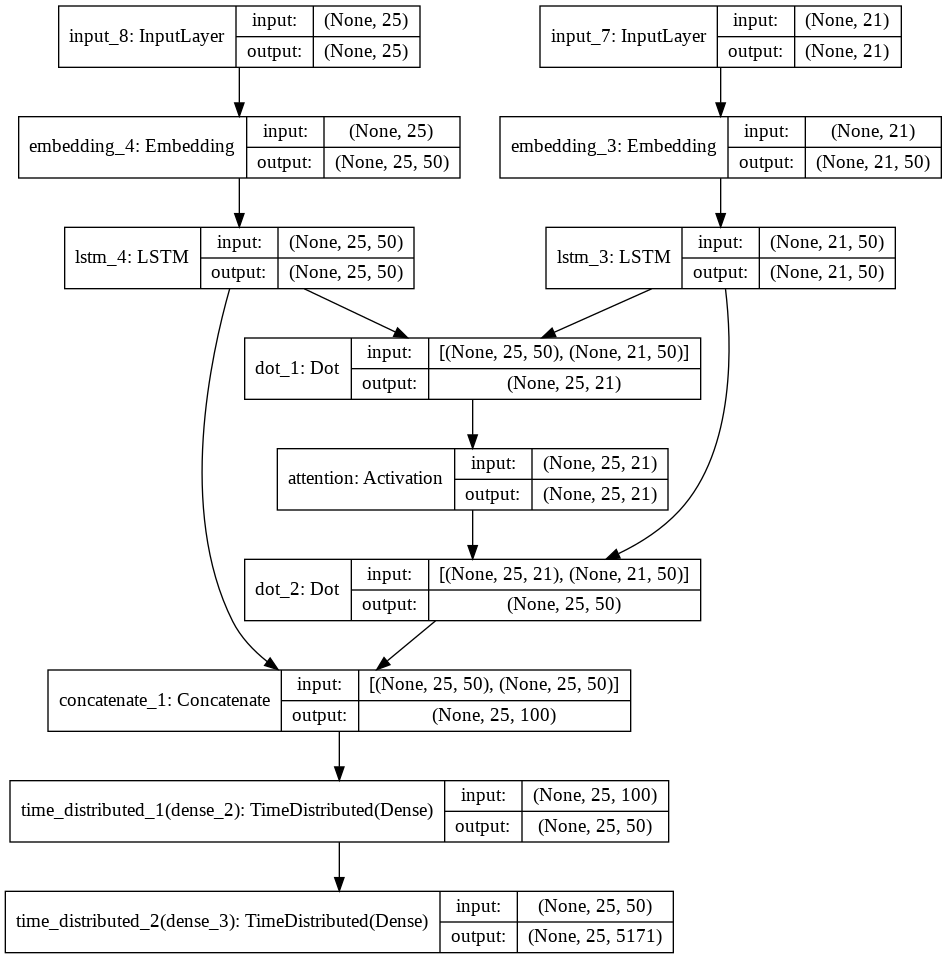

In [ ]:
from keras.utils import plot_model
plot_model(model_attention, to_file='model.png', show_shapes=True)

In [ ]:
history=model_attention.fit([encoder_input_data_train, decoder_input_data_train], decoder_target_data_train,
              batch_size=64,
              epochs=50,
              validation_split=0.15)
model_attention.save('seq2seq_attention_source_target.h5')

Train on 1210 samples, validate on 214 samples
Epoch 1/50
1210/1210 [==============================] - 13s 11ms/step - loss: 2.7536 - acc: 0.0979 - val_loss: 2.6370 - val_acc: 0.1060
Epoch 2/50
1210/1210 [==============================] - 9s 7ms/step - loss: 2.5222 - acc: 0.1063 - val_loss: 2.5933 - val_acc: 0.1060
Epoch 3/50
1210/1210 [==============================] - 9s 7ms/step - loss: 2.4495 - acc: 0.1063 - val_loss: 2.5949 - val_acc: 0.1060
Epoch 4/50
1210/1210 [==============================] - 9s 7ms/step - loss: 2.4131 - acc: 0.1063 - val_loss: 2.6171 - val_acc: 0.1060
Epoch 5/50
1210/1210 [==============================] - 9s 7ms/step - loss: 2.3919 - acc: 0.1063 - val_loss: 2.6094 - val_acc: 0.1060
Epoch 6/50
1210/1210 [==============================] - 9s 7ms/step - loss: 2.3703 - acc: 0.1065 - val_loss: 2.6219 - val_acc: 0.1060
Epoch 7/50
1210/1210 [==============================] - 9s 7ms/step - loss: 2.3548 - acc: 0.1064 - val_loss: 2.6539 - val_acc: 0.1060
Epoch 8/50
12

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:896: UserWarning: Layer lstm_8 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'strided_slice_2:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'strided_slice_2:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


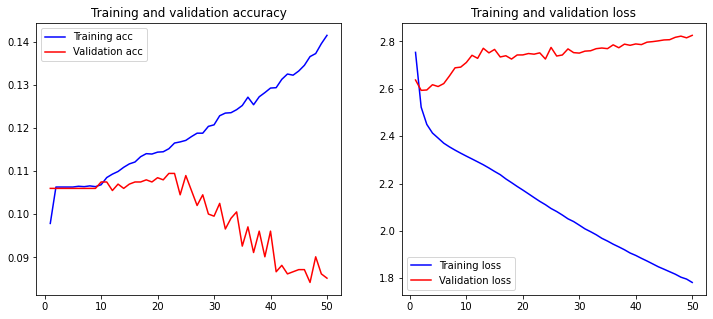

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
def decode_sequence_attention(input_seq):
    decoded_sentence = ''
    # encoder input
    encoder_input = input_seq.reshape(1,max_source_seq_length)
    # create blank matrix for decoder data
    decoder_input = np.zeros(shape=(len(encoder_input), max_target_seq_length))
    # update the first element with the start index
    decoder_input[:,0] = target_token_index['START_']
    # loop through the max length
    for i in range(1, max_target_seq_length):
        # Predict the index of the next word
        output = model_attention.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    # Reverse to get the sentence from the word index
    for d in decoder_input[:,0:][0]:
        if (reverse_target_char_index[d] == '_END'):
            decoded_sentence += ' '+reverse_target_char_index[d]
            break
        decoded_sentence += ' '+reverse_target_char_index[d]
    return decoded_sentence.strip()

In [ ]:
print(target_texts_train[10])
print(decode_sequence_attention(encoder_input_data_train[10]))

START_  অনুষ্ঠানটির স্লোগান ছিল ‘শিশুশ্রম আমরা চিরদিনের জন্য বিদায় করব’ _END
START_ কিন্তু ‘ এ এ কোনো একটি জন্য কাজ ছিল ছিল _END


In [ ]:
len(encoder_input_data_test)

357

In [ ]:
actual_attention, predicted_attention = list(), list()
for seq_index in range(len(encoder_input_data_test)):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sent = decode_sequence_attention(input_seq)
    predicted_attention.append(nltk.word_tokenize(decoded_sent))
    actual_attention.append([nltk.word_tokenize(target_texts_test[seq_index])])

In [ ]:
print("BLEU Score : ")
print('BLEU-1: %f' % corpus_bleu(actual_attention, predicted_attention, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_attention, predicted_attention, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_attention, predicted_attention, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_attention, predicted_attention, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU Score : 
BLEU-1: 0.216520
BLEU-2: 0.042173
BLEU-3: 0.149630
BLEU-4: 0.205360


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
score = corpus_bleu(actual_attention,  predicted_attention)
print(score*100)

22.31408329362082


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
